In [ ]:
"""Hartree-Fock Procedure for Approximate Quantum Chemistry"""

__authors__ = ["Ashley Ringer McDonald","Dominic A. Sirianni", "Tricia D. Shepherd", "Sean Garrett-Roe"]
__email__   = ["armcdona@calpoly.edu", "sirianni.dom@gmail.com", "profshep@icloud.com", "sgr@pitt.edu"]
__credits__ = ["Daniel G.A. Smith"]
__copyright__ = "(c) 2008-2020, The Psi4Education Developers"
__license__   = "BSD-3-Clause"
__date__      = "2020-07-28"

## Hartree-Fock Procedure for Approximate Quantum Chemistry

In [1]:
import psi4
import numpy as np
from scipy import linalg as splinalg

### I. Warm up with the H atom
By solving the Hydrogen atom Schrödinger equation, we saw that the expression for the different
energy levels is given by:

$$E_{n} = -\frac{m_e e^4}{8\epsilon_0^2h^2n^2}=-\frac{m_ee^4}{2(4\pi\epsilon_0)^2\hbar^2n^2}\qquad(1)$$

Atomic units (a.u.) are based on fundamental quantities so that many physical constants have numerical values of 1: 

| Symbol | Quantity | Value in a.u. | Value in SI units
|---|---|---|---|
| $e$ | electron charge| 1 |$1.602\times 10^{-19}$ C |
| $m_e$ | electron mass| 1 |$9.110\times 10^{-31}$ kg |
| $\hbar$ | angular momentum| 1 |$1.055\times 10^{-34}$ J s |
| $a_0$ | Bohr radius (atomic distance unit)| 1 |$5.292\times 10^{-11}$ m |
| $E$ | Hartree energy (atomic energy unit)| 1 |$4.360\times 10^{-18}$ J |
| $4\pi\epsilon_0$ | vacuum permittivity| 1 |$1.113\times 10^{-10}$ C$^2$/J m |. 

#### Question:  Verify that the two forms of Eq.1 agree.

**Answer:** 

$$E_n = -\frac{m_e e^4}{8\epsilon_0^2 h^2 n^2}    = -\frac{m_e e^4}{2(4\pi\epsilon_0)^2n^2 (\frac{h^2}{(2\pi)^2})}$$
$$-\frac{m_e e^4}{8\epsilon_0^2 h^2 n^2}      = -\frac{(2\pi)^2m_e e^4}{2(4\pi\epsilon_0)^2h^2n^2}$$
$$-\frac{m_e e^4}{8\epsilon_0^2 h^2 n^2}      = -\frac{4\pi^2m_e e^4}{32\pi^2\epsilon_0^2h^2n^2}$$
$$\therefore -\frac{m_e e^4}{8\epsilon_0^2 h^2 n^2} = -\frac{m_e e^4}{8\epsilon_0^2 h^2 n^2}$$



#### Question:  Rewrite $E_n$ in atomic units.

**Answer:** 
$$E_n = -\frac{m_e e^4}{2(4\pi\epsilon_0)^2n^2\hbar^2}$$

$$E_n = \frac{(1)(1)^4}{2(1)^2n^2 (1)^2}$$
$$E_n = \frac{1}{2n^2} $$

#### Calculate: In the cell below, write the formula to compute the exact H atom ground state energy in SI units and explicitly convert from SI to hartrees

In [2]:
# ==> Toy Example: The Hydrogen Atom <==

# Define fundamental constants in SI units
m_e = 9.1093837015e-31 # kg
e = 1.602176634e-19 # C
epsilon_0 = 8.8541878128e-12 # F / m
h = 6.62607015e-34 # J*s
hbar = h/(2*np.pi)
n = 1

# Define a.u. to SI energy conversion factor (https://en.wikipedia.org/wiki/Hartree)
hartree2joules = 4.359744650e-18

# Compute ground state energy of H atom in SI units using constants above
E_1 = -m_e*(e**4)/(8*epsilon_0**2*h**2*n**2)

# Convert to atomic units
E_1_au = E_1/hartree2joules

print(f'The exact ground state energy of the H atom in SI units is: {E_1} J')
print(f'The exact ground state energy of the H atom in atomic units is: {E_1_au} Eh')

The exact ground state energy of the H atom in SI units is: -2.1798723610862185e-18 J
The exact ground state energy of the H atom in atomic units is: -0.5000000082771404 Eh


We obtained the Hydrogen atom energy expression above by solving the Schrödinger equation exactly. But what happens if we cannot do this?

That's where Hartree-Fock molecular orbital theory comes in! Just as a test case, let's use Psi4 to compute the Hartree-Fock wavefunction and energy for the Hydrogen atom:

#### Calculate: In the cell below, use psi4 to compute the exact H atom ground state energy in SI units and hartrees

In [3]:
# ==> Compute H atom energy with Hartree-Fock using Psi4 <==

# the H atom has a charge of 0, spin multiplicity of 2 (m_s=1/2)
# and we place it at the xyz origin (0,0,0)

h_atom = psi4.geometry("""
0 2
H 0 0 0
""")

# specify the basis
basis = 'd-aug-cc-pv5z'

# set computation options
psi4.set_options({'basis': basis,
                  'reference': 'rohf',
                  'scf_type': 'pk'})

# compute energy
e = psi4.energy('scf')
psi4.core.clean()

print(f"The Hartree-Fock ground state energy of the H atom in SI units is: {e * psi4.constants.hartree2J} J")
print(f"The Hartree-Fock ground state energy of the H atom in atomic units is: {e} Eh")

The Hartree-Fock ground state energy of the H atom in SI units is: -2.179849658362055e-18 J
The Hartree-Fock ground state energy of the H atom in atomic units is: -0.4999948009253375 Eh



In this lab activity, you will build and diagonalize the Fock matrix to determine the MO coefficients and energies for a molecule.  We will be using the functions of the Psi4 quantum chemistry software package to compute the integrals we need.  The following notebook will lead you through setting up your molecule, establishing the basis set, and forming and diagonalizing the Fock matrix.  Be sure to run each cell as your proceed through the notebook.

### II. The Hartree-Fock procedure
The Schrödinger equation has the structure of an eigenvalue equation

$$\hat{H}|\psi\rangle = E|\psi\rangle$$

In Hartree-Fock theory, this is reexpresed in terms of the Fock matrix, $F$, a matrix of wavefunction amplitudes for each MO, $C$, and the overlap matrix, $S$,

$$FC = SCE.\qquad(\text{2})$$

The Fock matrix for a closed-shell system is 
$$
F = H + 2J - K
$$
where $H$ is the one electron "core" Hamiltonian, $J$ is the Coulomb integral matrix, and $K$ is the exchange integral matrix. The definitions of $J$ and $K$ depend on the coefficients, $C$. We see here the central premise of SCF:  To get the Fock matrix, we need the coefficient matrix, but to compute the coefficient matrix we need the Fock matrix. When $S$ is not equal to the identity matrix (i.e. the basis is not orthonormal), then this is a pseudo-eigenvalue problem and is even harder to solve. This is our task.

We will
- review Dirac notation 
- introduce the overlap matrix 
- learn how to build an orthogonalization matrix
- learn how to calculate the density
- learn how to calculate the Coulomb and Exchange integral matrices
- learn how to diagonalize the Fock matrix
- build an iterative procedure to converge HF energy

### III. Orthogonalizing the AO basis set

Crash course in Dirac notation:

The wavefunction, $\psi(x)$ can be represented as a *column vector*, $|\psi\rangle$ . The complex conjugate of the wavefunction, $\psi^*(x)$ is also represented by a vector which is the complex conjugate transpose of $|\psi\rangle$. 

\begin{align}
\psi(x)&\rightarrow|\psi\rangle\quad\text{column vector}\\
\psi^*(x)&\rightarrow\langle\psi|\quad\text{row vector}
\end{align}

The normalization of a wavefunction $\psi(x)$ is an integral

$$\int\psi^*(x)\psi(x)\;\mathrm{d}x=1.$$

In Dirac notation, it is replaced with a vector equation

$$\langle\psi|\psi\rangle=1.$$

The orthogonality of two wavefunctions, $\psi_i(x)$ and $\psi_j(x)$, which, in integral notation, is

$$\int\psi_i^*(x)\psi_j(x)\;\mathrm{d}x=0,$$

becomes, in Dirac notation,

$$\langle\psi_i|\psi_j\rangle=0.$$
 
#### Calculate: Define two vectors, `phi1` and `phi2`, with two elements each, that are normalized, in the sense $\langle\phi_i|\phi_i\rangle=1$, and orthogonal in sense that $\langle\phi_i|\phi_j\rangle=0$. Recall that one defines a vector `v` with the two elements `1` and `2` through the command `v=np.array([1,2])`.

In [4]:
# define a first basis vector and a second, orthogonal vector
phi1 = np.array([1,0])
phi2 = np.array([0,1])

print(F'Phi1: {phi1}')
print(F'Phi2: {phi2}')
print()#empty line



Phi1: [1 0]
Phi2: [0 1]



Note: Numpy commands for vector operations assuming `v`= vector:

inner product (scalar product) of two vectors: `v.dot(v)`

complex conjugate of a vector: `v.conj()`

inner product of $v^\dagger v$: `v.conj().dot(v)`


#### Calculate: Use the commands demonstrated above to show that `phi1` is normalized.

In [5]:
# calculate normalization

phi1_norm = phi1.conj().dot(phi1)

print(F'<phi1|phi1> = {phi1_norm}')

<phi1|phi1> = 1


#### Calculate: Similarly, enter the three remaining calculations below to show that `phi1` and `phi2` are orthonormal.

In [6]:
# calculate normalization

print(F'<phi2|phi2> = {phi2.conj().dot(phi2)}')

# calculate orthogonality

print(F'<phi1|phi2> = {phi1.conj().dot(phi2)}')

print(F'<phi2|phi1> = {phi2.conj().dot(phi1)}')

<phi2|phi2> = 1
<phi1|phi2> = 0
<phi2|phi1> = 0


### IV. The overlap integrals
For a set of basis functions, $\phi_i(\tau)$, where $\tau$ is a shorthand for all the coordinates of all the particles, we can calculate the overlap integrals between the basis functions in the following way

$$S_{ij}=\int {\rm d}\tau\; \phi_i^*(\tau)\phi_j(\tau).$$

#### Question:  Define $S_{ij}$ using Dirac notation.

**Answer:** 

$$S_{ij} = \langle\phi_i^*|\phi_j\rangle$$

#### Question:  For an orthonormal basis, what does the overlap integral array, `S`, look like?

**Answer:** 
$\\$
$S_{ij} = 1$ when $i = j$, and $S_{ij} = 0$ when $i \neq j$. Therefore, $S_{ij}$ will look like an n x n matrix, with the diagonal terms--representing i = j-- equal to 1, and every other entry equal to 0.

$$
S_{ij} =
\begin{equation*}
    \begin{pmatrix}
    1 & 0 & \cdots & 0 \\
    0 & 1 & \cdots & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    0 & 0 & \cdots & 1
    \end{pmatrix}
\end{equation*}
$$

#### Calculate: the terms `S_ij` using the basis vectors `phi1` and `phi2`. 

In [7]:
# calculate the overlap (inner product) of the vectors 
S_11 = phi1.conj().dot(phi1)
S_12 = phi1.conj().dot(phi2)
S_21 = phi2.conj().dot(phi1)
S_22 = phi2.conj().dot(phi2)
print('The ij elements of S:')
print(S_11,S_12)
print(S_21,S_22)
print()


The ij elements of S:
1 0
0 1



### V. Constructing the overlap matrix
These overlap integrals, $S_{ij}$, can be interpreted as the elements on the $i$-th row and $j$-th column of a matrix, $S$. Let's propose a matrix, $S$, made of the overlap integrals $S_{ij}$. We can build $S$ systematically in the following way. First, make a matrix, $B$, composed of our basis vectors as columns,

$$ B = \left(\begin{array}{ccc}|& |&|\\ \phi_1 &\phi_2&\phi_3\\|&|&|\end{array}\right).$$

We will use the symbol $\dagger$ to indicate the complex conjugate of the transpose of a matrix. So

$$B^\dagger = (B^T)^*.$$

In [8]:
# construct the overlap matrix from matrix of basis vectors
vector_length = phi1.size #length of the vector space
phi1_column = phi1.reshape(vector_length,1) #this makes phi a column vector
phi2_column = phi2.reshape(vector_length,1)

# put together (concatenate) the vectors into the matrix B
B = np.concatenate((phi1_column,phi2_column),axis=1)
print(F'The matrix B:\n{B}')

B_dagger = B.conj().T
print(F'The matrix B^\dagger:\n{B_dagger}')

The matrix B:
[[1 0]
 [0 1]]
The matrix B^\dagger:
[[1 0]
 [0 1]]


Now, multiplying the rows of $B^\dagger$ by the columns of $B$ (normal matrix multiplication) produces a matrix of the overlap integrals in the correct locations. we defined to be the matrix $S$.

$$B^\dagger B =\left(\begin{array}{ccc}-& \phi_1^*&-\\-& \phi_2^* &-\\-&\phi_3&-\end{array}\right) \left(\begin{array}{ccc}|& |&|\\ \phi_1 &\phi_2&\phi_3\\|&|&|\end{array}\right)\equiv S.$$

Note: Numpy commands for matrix operations assuming `v` = vector, and `M` = matrix:

matrix vector product: `M.dot(v)`

matrix matrix product: `M.dot(M)`

matrix complex conjugate: `M.conj()`

matrix transpose: `M.T`

#### Calculate: Use `B` and `B_dagger` and the matrix rules above to calculate the matrix `S`.

In [9]:
# calculate S from matrix of basis vectors
S = B_dagger.dot(B)
print(F'The matrix of eigenvectors in columns B =\n {B} \n\nand S = B^\dagger B =\n{S}\n')

The matrix of eigenvectors in columns B =
 [[1 0]
 [0 1]] 

and S = B^\dagger B =
[[1 0]
 [0 1]]



### VI. Einstein implicit summation notation
Matrix multiplication is defined through

$$(AB)_{pq}= \sum_i A_{p,i}B_{i,q}\qquad\text{explicit summation}$$

Note that there is a repeated index, $i$, in the summation. In implicit summation notation, Einstein notation, we do not write the $\sum$ and treat the summation as understood. 

$$(AB)_{pq}=A_{p,i}B_{i,q}\qquad\text{implicit summation}$$

Using implicit summation for the case at hand, $B^\dagger B$ gives

$$S_{pq}=(B^\dagger B)_{pq}= (B^\dagger)_{p,i}B_{i,q}\qquad\text{implicit summation}$$
$$= (B^*)_{i,p}B_{i,q}\qquad\text{implicit summation}$$

where $B^*$ is the complex conjugate of $B$ (no transpose). Note that the two sets of indices, $(i,p)$ and $(i,q)$, in the input matrices become one set, $(p,q)$, in the product. 

*(Python programming aside: There is a convenient function in `numpy` called `einsum()`, which is one of the crown jewels of the numpy library.  In short, `einsum` lets you perform various combinations of multiplying, summing, and transposing matrices very efficiently.  A good tutorial about `einsum` can be found at http://ajcr.net/Basic-guide-to-einsum/.  To specify the operations you want to do, you use the **Ein**stein **Sum**mation convention.)*

To calculate the sum 

$$S_{pq} = (B^*)_{i,p}B_{i,q}\qquad\text{implicit summation}$$

use `S=np.einsum('ip,iq->pq',B.conj(),B)`, as demonstrated below. We will use `einsum()` in several places.

Let's try this with a simple basis set of two (perhaps) orthonormal vectors.

#### Question: Describe how the notation of the `np.einsum` command coorelates to the implicit summation formula written above.

****Answer**** 
np.einsum is related to the implicit summation formula above as it effectively allows for us to perform matrix multiplication given specific indices, allowing for a product with indices based off of the intial two matrices multiplied. The resultant matrix consists of the indices not shared between the two initial matrices.




#### Calculate: Use the function `np.einsum()` to calculate the matrix `S`, and confirm that your answer is the same as above.

In [10]:
# calculate S from Einstein sum
S = np.einsum('ip,iq->pq',B.conj(),B)
print(F'S from Einstein notation:\n{S}')

S from Einstein notation:
[[1 0]
 [0 1]]


#### Question: Propose a different orthonormal basis, modify `phi1` and `phi2`, and verify that `S` still has the same form. There are infinitely many choices. It isn't complex... or *is* it?!

$\phi_{1} = \begin{pmatrix} \frac{4}{5} \\ 0 \\ \frac{3}{5} \end{pmatrix}$
$\phi_{2} = \begin{pmatrix} \frac{1}{2} \\ \frac{\sqrt{11}}{6} \\ \frac{-4}{6} \end{pmatrix}$

In [11]:
phi1_new = np.array([4/5,0,3/5])
phi2_new = np.array([1/2,np.sqrt(11)/6,-4/6])
print(phi2_new.conj().dot(phi2_new))
print(int(phi2_new.conj().dot(phi1_new)))
print(int(phi1_new.conj().dot(phi2_new)))
print(phi1_new.conj().dot(phi1_new))

phi2_new_column = phi2_new.reshape(phi2_new.size,1)
phi1_new_column = phi1_new.reshape(phi1_new.size,1)

B_new = np.concatenate((phi1_new_column,phi2_new_column),axis=1)
B_new_dagger = B_new.conj().T
S_new = np.einsum('ip,iq->pq',B_new.conj(),B_new)
S_new = S_new.astype(int) ### Converts the float values in the matrix to integers
print(S_new)

1.0
0
0
1.0
[[1 0]
 [0 1]]


#### Question: Propose what will happen to `S` if the vectors are not orthonormal. 
#### Calculate: Test your prediction!

They will yield a matrix with values other than one and zero


In [12]:
phi1_test = np.array([10, 20])
phi2_test = np.array([30, 40])
phi1_col = phi1_test.reshape(phi1_test.size,1)
phi2_col = phi2_test.reshape(phi2_test.size,1)
B_test = np.concatenate((phi1_col,phi2_col),axis=1)
B_test_dagger = B_test.conj().T

S_test = np.einsum('ip,iq->pq',B_test.conj(),B_test)
print(S_test)

[[ 500 1100]
 [1100 2500]]


### VII. Gaussian atomic orbital basis set

H$_2$O is a small but interesting molecule to use in our exploration. 

#### Question:  Answer the following questions for the H$_2$O molecule:
##### How many electrons are there in total?

10

##### How many occupied molecular orbitals would you expect?


5

Before we can begin to implement the HF procedure, we need to specifcy the molecule and basis set that we will be using.  We will also set the memory usage for our calcluation and the output file name.  

In [13]:
# ==> Set Basic Psi4 Options <==
# Memory specification
psi4.set_memory('500 MB')
numpy_memory = 2 # No NumPy array can exceed 2 MB in size

# set output file
psi4.core.set_output_file('output.dat', False)

# specify the basis
# basis = 'cc-pvdz'
basis = 'sto-3g'


# Set computation options
psi4.set_options({'basis': basis,
                  'scf_type': 'pk',
                  'e_convergence': 1e-8})


# ==> Define Molecule <==
# Define our model of water -- 
# we will distort the molecule later, which may require C1 symmetry
mol = psi4.geometry("""
O
H 1 1.1
H 1 1.1 2 104
symmetry c1
""")

# compute energy

SCF_E_psi = psi4.energy('scf')
psi4.core.clean()

print(f"The Hartree-Fock ground state energy of the water is: {SCF_E_psi} Eh")

The Hartree-Fock ground state energy of the water is: -74.94207989868079 Eh


Next, we need to build the wavefunction from the basis functions.  We store the wavefunction in a variable called `wfn`. We use the function `nalpha()` provided by the wavefunction object we created above, `wfn`, to determine the number of orbitals with spin alpha, which will be doubly occupied orbitals for close shelled systems. We save this answer as a variable called `ndocc` (number of doubly occupied orbitals).  

#### Calculate: Execute the code below and confirm that the number of doubly occupied orbitals matches your expectation for the molecule you chose.

In [14]:
# ==> Compute static 1e- and 2e- quantities with Psi4 <==
wfn = psi4.core.Wavefunction.build(mol, psi4.core.get_global_option('basis'))

# number of spin alpha orbitals (doubly occupied for closed-shell systems)
ndocc = wfn.nalpha()
nbf = wfn.basisset().nbf()

print(F'Number of occupied orbitals: {ndocc}')
print(F'Number of basis functions: {nbf}') 

Number of occupied orbitals: 5
Number of basis functions: 7


Next we will examine the atomic orbital basis set. To do this, we have to set up a data structure, called a class, to calculate the molecular integrals. (Psi4 will do the nasty calculus for us.) We will call this data structure `mints` (Molecular INTegralS). We use the function `ao_overlap` to calculate the overlap integrals between all the AO basis functions.  We cast the result to a numpy array called `S`. 

_(Python programming aside: `asarray()` is a special case of `array()` that does not copy arrays when compatible and converts array subclasses to base class ndarrays. https://stackoverflow.com/questions/14415741/what-is-the-difference-between-numpys-array-and-asarray-functions)_ 

In [15]:
# Construct a molecular integrals object
mints = psi4.core.MintsHelper(wfn.basisset())

# Overlap matrix as a psi4 Matrix object
S_matrix = mints.ao_overlap()

# Overlap matrix converted into an ndarray
S = np.asarray(S_matrix) 

print(F'Shape of S is {S.shape}')

Shape of S is (7, 7)


#### Question: Explain the shape (number of rows and columns) of `S` in terms of the AO basis set we chose.

The shape of S is based on the number of basis functions that are used when we defined mol. Because we utilized sto-3g, we received a total of 7 basis functions. This is a result of:$\newline$
H --> 1s$_{val}$ $\newline$ 
H --> 1s$_{val}$ $\newline$
O --> 1s$_{core}$, 2s$_{val}$, 2px,y,z$_{val}$

From this we see that there are 2 1s$_{val}$ orbitals, 1 1s$_{core}$ orbital, 1 2s$_{val}$ orbital, and 3 2s$_{val}$ orbitals. The 3 types of valence orbitals each possess 2 basis functions, while the core orbital possesses only 1 basis function. This totals to 7 basis functions.

The shape of S is then determined through the creation of a matrix object based off of our basis set, which is 7X7 or a shape of (7,7).

Examine the contents of `S`.

In [16]:
print(S) #the full matrix may be somewhat hard to read based on the basis set

print(S.diagonal())

[[ 1.00000000e+00  2.36703937e-01  1.70032182e-17  0.00000000e+00
   0.00000000e+00  3.84055925e-02  3.84055925e-02]
 [ 2.36703937e-01  1.00000000e+00 -2.46744544e-17  0.00000000e+00
   0.00000000e+00  3.86138794e-01  3.86138794e-01]
 [ 1.70032182e-17 -2.46744544e-17  1.00000000e+00  0.00000000e+00
   0.00000000e+00  2.09726923e-01  2.09726923e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00 -2.68438220e-01  2.68438220e-01]
 [ 3.84055925e-02  3.86138794e-01  2.09726923e-01  0.00000000e+00
  -2.68438220e-01  1.00000000e+00  1.81759851e-01]
 [ 3.84055925e-02  3.86138794e-01  2.09726923e-01  0.00000000e+00
   2.68438220e-01  1.81759851e-01  1.00000000e+00]]
[1. 1. 1. 1. 1. 1. 1.]


In [17]:
# Look at the first few elements
def peak(S,nrows=4,ncols=4):
    print(F'Here is a peak at the first {nrows} x {ncols} elements of the matrix:\n{S[:nrows,:ncols]}')
    
peak(S)

Here is a peak at the first 4 x 4 elements of the matrix:
[[ 1.00000000e+00  2.36703937e-01  1.70032182e-17  0.00000000e+00]
 [ 2.36703937e-01  1.00000000e+00 -2.46744544e-17  0.00000000e+00]
 [ 1.70032182e-17 -2.46744544e-17  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


#### Question:  Based on your observations of `S` in the AO basis, answer the following questions
##### What do the diagonal elements of `S` indicate?

The diagonal elements of S indicate overlap integrals of S$_{ij}$ where i == j. 

##### What do the off-diagonal elements of `S` indicate?

The off-diagonal elements of S${ij}$ indicate overlap integrals where i$\neq$j

##### Does the Gaussian atomic orbital basis set form an orthonormal basis? 

It does not form an orthonormal basis as, while the diagonal consists of 1's, the off-diagonals do not consist of 0's.


We can perform this test programmatically as well, with a few python tricks. Construct an array of the same size as the overlap array (`S`) that has 1's along the diagonal and 0's everywhere else. Then compare that array to the `S` array to determine if the AO basis is orthonormal.

In [18]:
# example of testing for orthonormality
# define a function
def isBasisOrthonormal(S):
    # get the number of rows of S
    size_S = S.shape[0] 
    
    # construct an identity matrix, I -- "eye", get it?!? Ha ha! Math is so funny!
    identity_matrix = np.eye(size_S) 

    # are all elements of S numerically close to the identity matrix? 
    # We won't test for equality because there can be very small numerical 
    # differences that we don't care about
    orthonormal_check = np.allclose(S, identity_matrix)

    print(F'Q:(T/F) The AO basis is orthonormal? A: {orthonormal_check}')
    return orthonormal_check

# use the function
isBasisOrthonormal(S)

Q:(T/F) The AO basis is orthonormal? A: False


False

#### Question: Does the result agree with what you determined above? Explain.

Yes, this agrees with what I determined above because it shows that S does not possess the same characteristics as an identity matrix.

### VIII. An orthogonalization matrix
Recall that if we had used the hydrogen atom wavefunctions as our basis set, the AO wavefunctions would all be orthonormal. Since we used a basis set of Gaussian wavefuctions, this may not be the case. We will now introduce some tools to fix it!

Since our AO basis set was not orthonormal, we seek to construct an orthogonalization matrix, $A$, such that ${\bf A}^{\dagger}{\bf SA} = {\bf 1}$. 

**Motivation:** If ${\bf A}$ and ${\bf S}$ were real numbers $a$ and $s$ (not matrices), this would be simple to solve. First, $a^\dagger=a$ because a real number is the same as its hermitian transpose. By simple algebra we can solve for a,

$$a^\dagger s a=1$$
$$a^\dagger s a=a s a=a^2s=1$$
$$\Rightarrow{}a=s^{-1/2}$$ 

In linear algebra (with matrices instead of numbers) this is more complicated, but numpy and the mints class can take care of the details for us! Leaving out the details, we will calculate

$${\bf A}={\bf S}^{-1/2}$$.

#### Calculate: Use the function `np.linalg.inv()` to calculate the inverse of `S`, and the function `splinalg.sqrtm()` to take its (matrix) square root. Execute the code below and examine the matrix `A`.

In [19]:
# ==> Construct AO orthogonalization matrix A <==

# inverse of S using np.linalg.inv
# matrix square root of the inverse of S using splinalg.sqrtm

A = splinalg.sqrtm(np.linalg.inv(S))

peak(A)

Here is a peak at the first 4 x 4 elements of the matrix:
[[ 1.02363458 -0.13685468 -0.00748725  0.        ]
 [-0.13685468  1.15786316  0.07216005  0.        ]
 [-0.00748725  0.07216005  1.03830504  0.        ]
 [ 0.          0.          0.          1.        ]]


#### Question: What do you observe about the elements of `A`? Is the matrix real or complex? Is the matrix symmetric or not?
The elements of A are real, and the matrix is symmetric.

Our basis set $B$ is not orthonormal, so we want to take linear combinations of its columns to make a new basis set, $B'$, that is orthonormal. We define a new matrix, $A$, in terms of that transformation,

$$B' = BA.$$

The new overlap matrix will be

\begin{align}
 S' &= B'^\dagger B',\\
 &= (BA)^\dagger (BA),\\
&= A^\dagger B^\dagger BA,\\
&= A^\dagger S A.
\end{align}
The matrix $A$ makes the proper linear combination of the columns of $B$ and $A^\dagger$ makes the linear combinations of the rows of $B^\dagger$. This is a very common structure of transformation matrices. Because $S$ is real and symmetric, $A$ is also real and symmetric, so $A^\dagger=A$. The transformation becomes simply

$$S' = A S A.$$

#### Calculate: Use the orthogonalization matrix `A` to transform the overlap matrix, `S`. Check the transformed overlap matrix, `S_p`, to make sure it represents an orthonormal basis.

In [20]:
# Transform S with A and assign the result to S_p

S_p = A.dot(S).dot(A)

isBasisOrthonormal(S_p)

Q:(T/F) The AO basis is orthonormal? A: True


True

#### Question: The product A S A does not take the complex conjugate transpose of A. What conditions (properties of A) make that ok?

This is okay because the matrix A is both real and symmetric, therefore the complex conjugate transpose of A is just A, meaning it can be substituted with just a dot product with A.

### IX. The Fock Matrix Transformed to an Orthonormal Basis
We can now return to Eq.2 using our orthogonalization matrix $A$. A common linear algebra trick is to "insert one." In this case, the matrix $A$ times its inverse is, by definition the identity matrix, $AA^{-1}={\bf1}$. We can put that factor of one anywhere in an equation that is useful to us, and, then, typically we regroup terms in a way we want. In this case, we insert one  bewteen $FC$ and $SC$.

\begin{align}
FC&=SCE\\
F({\bf1})C&=S({\bf1})CE\\
FAA^{-1}C&=SAA^{-1}CE
\end{align}
Multiplying on the left by $A$ then gives

$$
AFAA^{-1}C=ASAA^{-1}CE
$$

We can recognize the transformation $S'=ASA$ on the right hand side and similarly define $F'=AFA$ on the left hand side. Lastly, we define a transformed coefficient matrix, $C'=A^{-1}C$. Our transformed Fock equation reads

\begin{align}
F'C'&=S'C'E,\\
&=C'E.
\end{align}

The last line follows because $S'={\bf1}$ in our new basis. We now have an eigenvalue problem that we can solve by matrix diagonalization.

In the expression

$$C'=A^{-1}C,$$

the matrix $A^{-1}$ transforms the coefficients, $C$, into the orthogonalized basis set. We will also need a way to transform those coefficients, $C'$, back to the original AO basis.

#### Question: Based on the definition of $C'$, propose a definition of $C$ in terms of $A$ and $C'$. Justify your equation.

**Answer:**

If we multiply both sides by A, we arrive at:
$$
\begin{equation}
AC' = AA^{-1}C
\end{equation}
$$
Given the fact that $AA^{-1} =1$, we can simply our equation to:
$$
\begin{equation}
AC'=(1)C
\newline
\therefore AC' = C
\end{equation}
$$

### X. Initial guess for the Fock Matrix is the one electron Hamiltonian
To get the Fock matrix, we need the coefficient matrix, but to compute the coefficient matrix we need the Fock matrix.  So we start with a guess for the Fock matrix, which is the core Hamiltonian matrix.

In [21]:
# Build core Hamiltonian
T = np.asarray(mints.ao_kinetic())
V = np.asarray(mints.ao_potential())
H = T + V

#### Calculate: In the cell below, use the core Hamiltonian matrix as your initial guess for the Fock matrix. Transform it with the same A matrix you used above.  To calculate the eigenvalues, `vals`, and eigenvectors, `vecs`, of matrix `M` using  `vals, vecs = np.linalg.eigh(M)`.

In [22]:
# Guess for the Fock matrix
F = H
# Transformed Fock matrix, F_p
F_p = A.T.dot(F).dot(A)
# Diagonalize F_p for eigenvalues & eigenvectors with NumPy
vals, vecs = np.linalg.eigh(F_p)
print(F_p)

[[-3.22545865e+01 -2.79149095e+00  8.61097741e-03  0.00000000e+00
   4.41764864e-17 -1.81296596e-01 -1.81296596e-01]
 [-2.79149095e+00 -8.23688906e+00 -2.28292545e-01  0.00000000e+00
   4.67024056e-16 -3.85798621e-01 -3.85798621e-01]
 [ 8.61097741e-03 -2.28292545e-01 -7.45702942e+00  0.00000000e+00
  -6.21593995e-16 -1.10219580e-01 -1.10219580e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.34714481e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.30152923e-17  4.46998833e-16 -5.94738766e-16  0.00000000e+00
  -7.54288895e+00  1.13212043e-01 -1.13212043e-01]
 [-1.81296596e-01 -3.85798621e-01 -1.10219580e-01  0.00000000e+00
   1.13212043e-01 -4.03295455e+00 -4.46465957e-02]
 [-1.81296596e-01 -3.85798621e-01 -1.10219580e-01  0.00000000e+00
  -1.13212043e-01 -4.46465957e-02 -4.03295455e+00]]


#### Calculate: Display, i.e., `print`, the coefficent matrix and confirm it the correct size

Now that we have the coefficents in the transformed basis, we need to go back and get the coefficients in the original AO basis.

#### Calculate: Use `A` and the formula you proposed previously to transform the coefficient matrix back to the AO basis. Confirm that the resulting matrix appears reasonable, i.e., similar size and magnitude

In [23]:
# Transform the coefficient matrix back into AO basis

C = A.dot(vecs)
print(C)

[[-1.00154358e+00 -2.33624458e-01 -3.10299716e-16 -8.56842079e-02
   3.80285202e-16 -4.82226017e-02 -3.54935208e-15]
 [ 7.18933084e-03  1.05793876e+00  1.30046717e-15  3.60110465e-01
  -1.59437586e-15  4.63121174e-01  3.47238897e-14]
 [ 2.67129883e-04  4.27284243e-01 -4.37198565e-15 -9.39942475e-01
   4.30013812e-15  2.12940092e-01  1.65328837e-14]
 [ 0.00000000e+00 -2.77555756e-17 -2.81025203e-16  4.55191440e-15
   1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.76208366e-17 -3.25261154e-16 -1.06107023e+00  4.94793182e-15
  -2.39533711e-16 -2.24077756e-14  2.96507060e-01]
 [-1.82134850e-03 -1.49253289e-01 -1.37720978e-01  3.78578935e-02
  -2.19891752e-16 -7.80700283e-01  8.50140251e-01]
 [-1.82134850e-03 -1.49253289e-01  1.37720978e-01  3.78578935e-02
  -1.41443126e-16 -7.80700283e-01 -8.50140251e-01]]


### XI. The Density Matrix
Recall, the Fock matrix is 

$$
F = H + 2J - K
$$
where $H$ is the one electron "core" Hamiltonian, $J$ is the Coulomb integral matrix, and $K$ is the exchange integral matrix. The HF energy can be expressed in explicit terms of one and two electron integrals
$$
E_{HF} = \sum_i^{elec}\langle i|h_i|i\rangle + \sum_{i>j}^{elec}[ii|jj]-[ij|ji]
$$
Expanding the orbitals in terms of basis functions, we find
$$
[ii|jj]=\sum_{pqrs}c^*_{pi}c_{qi}c^*_{rj}c_{sj}\int{\rm d}\tau\; \phi_p^*(1)\phi_q(1)\frac{1}{r_{ij}}\phi_r^*(2)\phi_s(2)\qquad{\text{(3)}}
$$


First, look at the coefficients in Eq.3. They come in two pairs of complex-conjugates, $c^*_{pi}c_{qi}$ and $c^*_{ri}c_{si}$. The diagonal terms, when $p=q$ for example, are the probability of some basis function $p$ contributing to the MO $i$. We will sum each term over the occupied orbitals, $i$, to form the "density matrix"
$$
D_{pq}=\sum_i^{occ} c^*_{pi}c_{qi}.
$$

We are going to construct the density matrix from the occupied orbitals.  To get a matrix of just the occupied orbitals, use the coefficient matrix in the original AO basis, and take a slice to include all rows and just the columns that represent the occupied orbitals.

In [24]:
# Grab occupied orbitals (recall: ndocc is the number of doubly occupied orbitals we found earlier)
C_occ = C[:, :ndocc]
print(F'The shape of C_occ is {C_occ.shape}')

The shape of C_occ is (7, 5)


#### Calculate: Build the density matrix, `D`, from the occupied orbitals, `C_occ`, using the function `np.einsum()`. (Recall Section VI.)

In [25]:
# Build density matrix from occupied orbitals

D = np.einsum('pi,qi ->pq',C_occ.conj(),C_occ)

print(F'The shape of D is {D.shape}')

The shape of D is (7, 7)


### XII. Coulomb and Exchange Integrals and the SCF Energy

The integral on the right of Eq.3 is super important. It has four indicies, $p,q,r,s$, so formally it is a tensor. It accounts for the repulsion between pairs of electrons, so it is called the electron repulsion integral tensor, $I$,
$$
I_{pqrs} = \int{\rm d}\tau\; \phi_p^*(1)\phi_q(1)\frac{1}{r_{ij}}\phi_r^*(2)\phi_s(2).
$$
First, we can build the electron-repulsion integral (ERI) tensor, which stores the electron repulsion between the atomic orbital wavefunctions. Mints does all the work for us!

In [26]:
# Build electron repulsion integral (ERI) Tensor
I = np.asarray(mints.ao_eri())

Eq.3 can be expressed in terms of $I$ and $D$ as
\begin{align}
[ii|jj] &= \sum_{pqrs}D_{pq}D_{rs}I_{pqrs},\\
&=\sum_{pq}D_{pq}\sum_{rs}D_{rs}I_{pqrs}.
\end{align}
The term $\sum_{rs}D_{rs}I_{pqrs}$ is the effective repulsion felt by one electron due to the other electrons in the system. This term is the Coulomb integral matrix
$$
J_{pq}=\sum_{rs}D_{rs}I_{pqrs}.
$$

#### Calculate: Define J  in terms of the density matrix, `D`, and the electron repulsion integral tensor, `I`, using `np.einsum()`.

In [27]:
#Define J
J = np.einsum('rs,pqrs->pq', D,I)

Similarly, 
\begin{align}
[ij|ji] &= \sum_{pqrs}D_{ps}D_{rq}I_{pqrs},\\
 &= \sum_{ps}D_{ps}\sum_{rq}D_{rq}I_{pqrs}.
\end{align}
corrects the repulsion due to electrons "avoiding each other" due to their Fermionic (antisymmetric w.r.t. exchange) character. This term is the exchange integral matrix
$$
K_{ps}=\sum_{rq}D_{rq}I_{pqrs}.
$$

#### Calculate: Define K  in terms of the density matrix, `D`, and the electron repulsion integral tensor, `I`, using `einsum()`. 

In [28]:
#Define K
K = np.einsum('rq,pqrs->ps',D,I)

#### Calculate: Define F in terms of H, J, and K. (Recall Section XI.)

In [29]:
#Define F as a function of H, J, and K

F = H + (2*J) - K

A more convenient form of the SCF energy is in terms of a sum over the AO basis functions
$$
E =  E_{nuc} + \sum_{pq}(H_{pq} + F_{pq})D_{pq},
$$
where $E_{nuc}$ is the nuclear repulsion, which psi4 can calculate for us as well.

#### Calculate: SCF energy based on H, F, and D using `np.einsum()`. 
*(Hint: The right hand side of the equation is the sum of the product of two terms, each of which has two indices (p and q). The result, E, is a number, so it has no indices. In `einsum()` notation, this case will be represented with the indices for the matrices on the left of the `->`, and no index on the right of the `->`. For example, in the case of just one matrix, the sum of all its elements of a matrix `M` is `sum_of_m = np.einsum('pq->',M )`. In your answer below, be sure to account for any modifications required of an element-wise product of two matrices.)* 

Deriving the Above Result


\begin{align}
E    = E_{nuc} + \sum_{pq} (H_{pq} + F_{pq})D_{pq}\\
\newline=
E_{nuc} + \sum_{pq} H_{pq}D_{pq} + \sum_{pq} F_{pq}D_{pq}
\end{align}


We know this equality is correct, as H, F, and D share the same dummy indices, $\textit{p}$ and $\textit{q}$. The distributive property is observed in this case, as the indices are conserved on both sides of the following equation:
$$
\begin{equation}
\newline
(H_{pq} + F_{pq})D_{pq} = H_{pq}D_{pq} + F_{pq}D_{pq}
\newline
\end{equation}
$$

This is because, as we distribute $D_{pq}$ across the terms within the parenthesis, no unique indices exist in the newly generated products, as indices $\textit{p}$ and $\textit{q}$ are shared between the original terms. Therefore, as the indices are conserved throughout the distribution, we can safely treat the second term (the summation term) of the above equation as a distributive case, allowing us to sum together H.dot(D) and F.dot(D). In Einstein notation, as we are utilizing the same indices for this summation, no unique transformations of the matrix will be needed, and as mentioned in the above textblock, we can simply utilize np.einsum('indice->, Matrix) to generate our E value (assuming we've first summed together the values of HD and FD before using einsum, followed by a subsequent addition of the $E_{nuc}$ term to complete our equation.)



Source: https://www.youtube.com/watch?v=-hOhhRe2gSA&ab_channel=FacultyofKhan Timestamp $\approx 5.00 min$

In [30]:

E_nuc = mol.nuclear_repulsion_energy()
H_D = np.einsum('pq,pq->',H,D)
F_D = np.einsum('pq,pq->',F,D)
#H_F_D = H_D + F_D
#SCF_E = E_nuc + np.einsum('pq->',H_F_D)
SCF_E = E_nuc + H_D + F_D
print(F'Energy = {SCF_E:.8f}')

Energy = -73.28579644


#### Question: Based on the result of the calculation in Section VII, is this a reasonable answer? 

**Answer:** 

Yes, this a reasonable answer for the SCF energy.

#### Question: Describe a procedure (i.e. identify the steps/commands) that will updated coefficients and compute a new density matrix based on the new definition of the Fock matrix. (Recall Section X)

**Answer** 
With each successive iteration, one can update coefficients, and thereby update the density matrix, by choosing a new guess for F, adding it to our core Hamiltonian. Because the core Hamiltonian doesn't change, our new guess would just be F = H + the previous density matrix acting on the two electron integrals. This yields:

$$
F_{\mu \nu} = H_{\mu \nu} + D_{\lambda \sigma} \sum_{\lambda \sigma} \left[(\mu \nu | \lambda \sigma) - \frac{1}{2}(\mu \lambda | \nu \sigma)\right]
$$

From there, we would continue as we did above, transforming and diagonalizing the Fock matrix to build a new coefficient matrix. This newly built coefficient matrix will then be used to calculate a new density matrix from the occupied orbitals of C. From there we can compare our new density matrix, $D^{i+1}$ to our previous density matrix, $D^{i}$ and if they are sufficiently similar, we can move on, otherwise we iterate by increasing i by 1, and repeat until this final condition is met.

This test for convergence in terms of density matrices is defined as testing the RMS of D through:

$$
D_{RMS} = \left[\left(\sum_{\mu \nu}^{AO} D_{\mu \nu}^{i} - D_{\mu \nu}^{i-1}\right)^{2}\right]^{\frac{1}{2}} < \delta_{D}
$$
In terms of the algorithm provided below,however, an approach centered around converging based on energy is made, rather than through comparison of the density matrices--which is typically reported in literature$^{1, 2}$. With this alternative option, we can simply calculate the new SCF energy with our new density matrix, and just compare that to the original SCF energy, and test whether or not the energy converges.


Sources: 
1: https://www.youtube.com/watch?v=x-O3_t4GVy8&t=338s&ab_channel=TMPChem


2: Chatfield, D. Christopher J. Cramer: Essentials of Computational Chemistry, Wiley, 2004, 126-9

#### Calculate: Using the procedure proposed above, calculate the updated coefficients

In [31]:
# Update density matrix
F = H
### Not actually part of the recalculation process; I just put this here so it doesn't interfere with the next block.
F_p = A.T.dot(F).dot(A)
vals, vecs = np.linalg.eigh(F_p)
C = A.dot(vecs)
C_occ = C[:, :ndocc]
D = np.einsum('pi,qi ->pq',C_occ.conj(),C_occ)
I = np.asarray(mints.ao_eri())
J = np.einsum('rs,pqrs->pq', D,I)
K = np.einsum('rq,pqrs->ps',D,I)
F = H + (2*J) - K



H_D = np.einsum('pq,pq->',H,D)
F_D = np.einsum('pq,pq->',F,D)
SCF_E = E_nuc + H_D + F_D




You have just completed one cycle of the SCF calculation!


Now we will use the density matrix to build the Fock matrix.  The code block below sets up a skeleton of the Hartree-Fock procedure.  The basic steps are:
1. Calculate the Fock Matrix based on the density matrix previously defined from a one electron hamiltonian
2. Calculate the energy from the Fock matrix.
3. Check and see if the energy has converged by comparing the current energy to the previous energy and seeing if it is within the convergence threshold.
4. If the energy has not converged, transform the Fock matrix, and diagonalize the transformed Fock matrix to get the energy and MO coefficients.  Then transform back to the original AO basis, pull the occupied orbitals, and reconstruct the density matrix. 

In [32]:
# ==> Nuclear Repulsion Energy <==
E_nuc = mol.nuclear_repulsion_energy()

# ==> SCF Iterations <==
# Pre-iteration energy declarations
SCF_E = 0.0
E_old = 0.0


# ==> Set default program options <==
# We continue recalculating the energy until it converges to the level we specify.  
# The varible `E_conv` is where we set this level of convergence.  We also set a 
# maximum number of iterations so that if our calculation does not converge, it 
# eventually stops and lets us know that it did not converge.  
# Maximum SCF iterations
MAXITER = 40
# Energy convergence criterion
E_conv = 1.0e-15

print('==> Starting SCF Iterations <==\n')

# Begin Iterations
for scf_iter in range(1, MAXITER + 1):
    
    # Build Fock matrix (Section XII)
    
    I = np.asarray(mints.ao_eri())
    J = np.einsum('rs,pqrs->pq', D,I)
    K = np.einsum('rq,pqrs->ps',D,I)
    F = H + (2*J) - K
    # <your code here>

    # Compute SCF energy
    
    H_D = np.einsum('pq,pq->',H,D)
    F_D = np.einsum('pq,pq->',F,D)
    SCF_E = E_nuc + H_D + F_D
    
    print(F'SCF Iteration {scf_iter}: Energy = {SCF_E:.8f} dE = {SCF_E - E_old:.8f}')
    
    # Check to see if the energy is converged.  If it is break out of the loop.
    # If it is not, set the current energy E_old
    
    if (abs(SCF_E - E_old) < E_conv):
        break
    E_old = SCF_E
    
    # Compute new coefficient & density matrices (Section X & XI) 
    F_p = A.T.dot(F).dot(A)
    vals, vecs = np.linalg.eigh(F_p)
    C = A.dot(vecs)
    C_occ = C[:, :ndocc]
    D = np.einsum('pi,qi ->pq',C_occ.conj(),C_occ)
    # <your code here>  
    
    # MAXITER exceeded?
    if (scf_iter == MAXITER):
        psi4.core.clean()
        raise Exception("Maximum number of SCF iterations exceeded.")

# Post iterations
print('\nSCF converged.')
print(F'Final RHF Energy: {SCF_E:.6f} [Eh]')

==> Starting SCF Iterations <==

SCF Iteration 1: Energy = -73.28579644 dE = -73.28579644
SCF Iteration 2: Energy = -74.82812526 dE = -1.54232882
SCF Iteration 3: Energy = -74.93548796 dE = -0.10736270
SCF Iteration 4: Energy = -74.94147771 dE = -0.00598975
SCF Iteration 5: Energy = -74.94197197 dE = -0.00049425
SCF Iteration 6: Energy = -74.94205603 dE = -0.00008407
SCF Iteration 7: Energy = -74.94207439 dE = -0.00001836
SCF Iteration 8: Energy = -74.94207862 dE = -0.00000423
SCF Iteration 9: Energy = -74.94207960 dE = -0.00000098
SCF Iteration 10: Energy = -74.94207983 dE = -0.00000023
SCF Iteration 11: Energy = -74.94207988 dE = -0.00000005
SCF Iteration 12: Energy = -74.94207989 dE = -0.00000001
SCF Iteration 13: Energy = -74.94207990 dE = -0.00000000
SCF Iteration 14: Energy = -74.94207990 dE = -0.00000000
SCF Iteration 15: Energy = -74.94207990 dE = -0.00000000
SCF Iteration 16: Energy = -74.94207990 dE = -0.00000000
SCF Iteration 17: Energy = -74.94207990 dE = -0.00000000
SCF It

Compare your results to Psi4 by computing the energy using `psi4.energy()` in the cell below.  

In [33]:
# ==> Compare our SCF to Psi4 <==
# Call psi4.energy() to compute the SCF energy
SCF_E_psi = psi4.energy('SCF')
psi4.core.clean()

# Compare our energy value to what Psi4 computes
assert psi4.compare_values(SCF_E_psi, SCF_E, 6, 'My SCF Procedure')

    My SCF Procedure......................................................................PASSED


#### Question: Modify the value of E_conv and describe its affect the number of iterations.


Decreasing the size of E_conv increases the number of iterations required, whereas increasing its size decreased the amount of iterations required to converge.


### XIII. Using Hartree-Fock to Justify Molecular Structure

Why is CO$_2$ linear? Why is H$_2$O bent? Why is CH$_4$ tetrahedral? Why is FeF$_6$ octahedral? In general
chemistry, we used valence shell electron pair repulsion (VSEPR) theory to justify molecular structures
by invoking a _repulsion_ between both bonding and non-bonding pairs of electrons.  The reality of molecular
structure is more complicated, however.

In this section of the lab, we will use the same Hartree-Fock method that we implemented above to justify the
bent structure of water by computing the electronic energy of H$_2$O at a variety of bond angles.  


In [36]:
# ==> Scanning a Bond Angle: Flexible Water <==
# Import a library to visualize energy profile
import matplotlib.pyplot as plt
%matplotlib inline

# Define flexible water molecule using Z-matrix
flexible_water = """
O
H 1 0.96
H 1 0.96 2 {}
"""

# Scan over bond angle range between 90 & 180, in 5 degree increments
scan = {}
for angle in range(60, 150, 5):
    # Make molecule
    mol = psi4.geometry(flexible_water.format(angle))
    # Call Psi4
    e = psi4.energy('scf/cc-pvdz', molecule=mol)
    #e = psi4.energy('scf/sto-3g', molecule=mol)

    # Save energy in dictionary
    scan[angle] = e

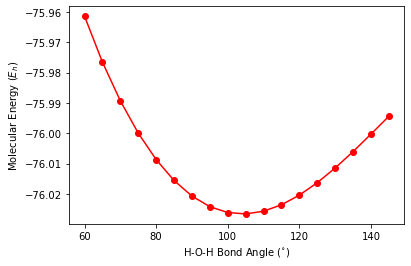

In [37]:
# Visualize energy profile
x = list(scan.keys())
y = list(scan.values())
plt.plot(x,y,'ro-')
plt.xlabel('H-O-H Bond Angle ($^{\circ}$)')
plt.ylabel('Molecular Energy ($E_h$)')
plt.show()

Using the energy profile we generated above, justify the experimentally measured water bond angle of 104.5$^{\circ}$ in the cell below.

**Answer**

Water's bond angle of 104.5 can be justified here, as we can see that there is a global minimum in energy at this angle, indicating that this angle is most energetically favorable for the geometry of water.


